In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint


2025-05-13 18:45:12.470764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 18:45:12.565082: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 18:45:12.659708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747136712.759437 1580389 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747136712.783442 1580389 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747136712.936399 1580389 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Load the dataset
file_path = "ecoli_data.txt"  # Replace with your file path
columns = ["ID", "sgRNA_sequence", "Location", "Strand", "E_score", "GC_Polyt", "S_score", "Offtarget_detail", "E_S_score"]
data = pd.read_csv(file_path, sep="\t", names=columns, skiprows=1)

# Display the first few rows of the dataset
data.head()

,ID,sgRNA_sequence,Location,Strand,E_score,GC_Polyt,S_score,Offtarget_detail,E_S_score
0,1,CGTTGCAGTCAGAATGAAAA,3,+,10,"[0.4,No]",0,"(PAM=NGG)[0mismatch,1mismatch,2mismatches,3mis...",10
1,2,ACGGGCAATATGTCTCTGTG,20,-,10,"[0.5,No]",0,"(PAM=NGG)[0mismatch,1mismatch,2mismatches,3mis...",10
2,3,TCTGATAGCAGCTTCTGAAC,58,-,10,"[0.45,No]",0,"(PAM=NGG)[0mismatch,1mismatch,2mismatches,3mis...",10
3,4,TCTGTGCGCTATGCCTATAT,139,+,10,"[0.45,No]",0,"(PAM=NGG)[0mismatch,1mismatch,2mismatches,3mis...",10
4,5,GGTGGTGCTAATGCGTTTCA,190,+,10,"[0.5,No]",0,"(PAM=NGG)[0mismatch,1mismatch,2mismatches,3mis...",10


In [4]:
# Preprocess the data
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    return np.array([mapping[base] for base in sequence])

# Encode sgRNA sequences
data['encoded_sequence'] = data['sgRNA_sequence'].apply(one_hot_encode)

# Pad sequences to ensure uniform length
max_length = max(data['encoded_sequence'].apply(len))
data['encoded_sequence'] = data['encoded_sequence'].apply(lambda x: np.pad(x, ((0, max_length - len(x)), (0, 0)), mode='constant'))

# Prepare features (X) and target (y)
X = np.stack(data['encoded_sequence'].values)
y = data['E_S_score'].values

# Normalize target values
y = y / y.max()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Build the model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(max_length, 4)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')  # Predicting a continuous value (E+S score)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/home/ryanl/Documents/Codes/BIOLOGY/Project/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-13 18:45:24.169969: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,817 (292.25 KB)

 Trainable params: 74,817 (292.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from scipy.stats import pearsonr

# Train the model
checkpoint = ModelCheckpoint("crispr_model.h5", save_best_only=True, monitor="val_loss", mode="min")

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint]
)

# ----- GC-content vs. prediction error correlation -----
# Compute GC-content for each test sequence from one‐hot encoding (C at index 1, G at index 2)
gc_test = (X_test[:, :, 1] + X_test[:, :, 2]).sum(axis=1) / max_length

# Predict on test set and compute absolute errors
preds = model.predict(X_test).flatten()
errors = np.abs(preds - y_test)

# Pearson correlation
corr, pval = pearsonr(gc_test, errors)
print(f"Pearson correlation (GC-content vs. error): {corr:.4f}, p-value={pval:.2e}")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4414e-06 - mae: 9.4287e-04

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4551e-06 - mae: 9.4663e-04 - val_loss: 3.1283e-06 - val_mae: 0.0017
Epoch 2/100
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1155e-06 - mae: 0.0014

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9969e-06 - mae: 0.0014 - val_loss: 4.6705e-07 - val_mae: 5.9827e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1827e-07 - mae: 6.9052e-04 - val_loss: 2.4521e-06 - val_mae: 0.0015
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6717e-06 - mae: 0.0024 - val_loss: 8.9329e-07 - val_mae: 8.1631e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6023e-06 - mae: 0.0010 - val_loss: 6.6409e-06 - val_mae: 0.0025
Epoch 6/100
 88/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2721e-06 - mae: 9.0173e-04

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2370e-06 - mae: 8.8718e-04 - val_loss: 1.8519e-07 - val_mae: 3.4225e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9497e-06 - mae: 0.0011 - val_loss: 3.0491e-07 - val_mae: 4.5261e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9753e-06 - mae: 0.0016 - val_loss: 1.7523e-05 - val_mae: 0.0042
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0093e-06 - mae: 0.0016 - val_loss: 6.5113e-07 - val_mae: 7.3756e-04
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7865e-06 - mae: 0.0011 - val_loss: 1.6180e-06 - val_mae: 0.0012
Epoch 11/100
 93/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9834e-06 - mae: 0.0012

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9960e-06 - mae: 0.0012 - val_loss: 1.7019e-07 - val_mae: 3.2761e-04
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6245e-07 - mae: 8.0953e-04 - val_loss: 5.3923e-07 - val_mae: 6.6741e-04
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0263e-06 - mae: 0.0017 - val_loss: 4.2168e-06 - val_mae: 0.0020
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0039e-06 - mae: 0.0012 - val_loss: 2.1603e-06 - val_mae: 0.0014
Epoch 15/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1868e-06 - mae: 0.0012 - val_loss: 5.2979e-07 - val_mae: 6.2950e-04
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9620e-06 - mae: 0.0011 - val_loss: 7.2821e-06 - val_mae: 0.0027
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0892e-06 - mae: 0.0018 - val_loss: 1.7704e-07 - val_mae: 3.2865e-04
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1421e-06 - mae: 8.5682e-04 - val_

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0058e-06 - mae: 0.0020 - val_loss: 1.1485e-07 - val_mae: 2.7326e-04
Epoch 23/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6408e-07 - mae: 4.9864e-04 - val_loss: 5.0016e-07 - val_mae: 6.7987e-04
Epoch 24/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7628e-06 - mae: 0.0011 - val_loss: 4.8452e-07 - val_mae: 6.1622e-04
Epoch 25/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7918e-06 - mae: 0.0014 - val_loss: 1.3915e-06 - val_mae: 0.0012
Epoch 26/100
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9562e-07 - mae: 8.4341e-04

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9403e-07 - mae: 8.4240e-04 - val_loss: 8.9303e-08 - val_mae: 2.3606e-04
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4058e-06 - mae: 0.0016 - val_loss: 1.7276e-06 - val_mae: 0.0013
Epoch 28/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4431e-06 - mae: 0.0010 - val_loss: 2.8222e-07 - val_mae: 4.7066e-04
Epoch 29/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8670e-07 - mae: 6.9691e-04 - val_loss: 4.8128e-07 - val_mae: 6.4139e-04
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8582e-07 - mae: 5.1184e-04 - val_loss: 1.8914e-05 - val_mae: 0.0043
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4343e-06 - mae: 0.0016 - val_loss: 8.5639e-07 - val_mae: 8.6652e-04
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1297e-06 - mae: 8.8232e-04 - val_loss: 4.8025e-07 - val_mae: 6.3948e-04
Epoch 33/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3540e-06 - mae: 0

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5150e-06 - mae: 0.0013 - val_loss: 6.5461e-08 - val_mae: 2.0140e-04
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0495e-06 - mae: 0.0012 

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0464e-06 - mae: 0.0012 - val_loss: 4.1827e-08 - val_mae: 1.6292e-04
Epoch 38/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8752e-06 - mae: 0.0011 - val_loss: 4.6397e-06 - val_mae: 0.0021
Epoch 39/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6404e-06 - mae: 0.0018 - val_loss: 4.1825e-07 - val_mae: 6.0629e-04
Epoch 40/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7567e-07 - mae: 4.9236e-04 - val_loss: 3.9132e-07 - val_mae: 6.0892e-04
Epoch 41/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1796e-07 - mae: 6.3393e-04 - val_loss: 1.5801e-06 - val_mae: 0.0012
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2754e-06 - mae: 0.0016 - val_loss: 9.8636e-06 - val_mae: 0.0031
Epoch 43/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8154e-06 - mae: 0.0015 - val_loss: 4.2841e-06 - val_mae: 0.0020
Epoch 44/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7895e-06 - mae: 0.0011 - val_loss

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8150e-06 - mae: 0.0014 - val_loss: 2.7284e-08 - val_mae: 1.3292e-04
Epoch 66/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.6414e-07 - mae: 7.2590e-04 - val_loss: 1.4546e-07 - val_mae: 3.4432e-04
Epoch 67/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9913e-06 - mae: 0.0011 - val_loss: 1.9306e-07 - val_mae: 3.6442e-04
Epoch 68/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6675e-06 - mae: 0.0011 - val_loss: 4.1338e-07 - val_mae: 6.1288e-04
Epoch 69/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5318e-07 - mae: 6.5031e-04 - val_loss: 4.6303e-08 - val_mae: 1.7301e-04
Epoch 70/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9919e-06 - mae: 0.0010 - val_loss: 2.2813e-06 - val_mae: 0.0014
Epoch 71/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3700e-07 - mae: 6.0302e-04 - val_loss: 4.8913e-07 - val_mae: 6.8369e-04
Epoch 72/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1075e-06 - mae: 8

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7308e-06 - mae: 0.0014 - val_loss: 2.5514e-08 - val_mae: 1.2862e-04
Epoch 80/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0613e-06 - mae: 8.0862e-04 - val_loss: 1.8923e-06 - val_mae: 0.0014
Epoch 81/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0977e-06 - mae: 0.0013 - val_loss: 4.3201e-08 - val_mae: 1.6285e-04
Epoch 82/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8377e-06 - mae: 0.0011 - val_loss: 3.5601e-06 - val_mae: 0.0019
Epoch 83/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8719e-07 - mae: 7.9512e-04 - val_loss: 5.6046e-08 - val_mae: 1.9089e-04
Epoch 84/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9425e-06 - mae: 0.0014 - val_loss: 1.0715e-07 - val_mae: 2.5801e-04
Epoch 85/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6660e-07 - mae: 5.3722e-04 - val_loss: 2.7353e-08 - val_mae: 1.2944e-04
Epoch 86/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5555e-07 - mae: 5.011

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8019e-07 - mae: 5.2409e-04 - val_loss: 1.7555e-08 - val_mae: 1.0410e-04
Epoch 89/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1297e-07 - mae: 3.6452e-04 - val_loss: 1.3570e-07 - val_mae: 2.9405e-04
Epoch 90/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3142e-07 - mae: 7.9203e-04 - val_loss: 2.8243e-06 - val_mae: 0.0016
Epoch 91/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3108e-06 - mae: 0.0012 - val_loss: 7.1857e-08 - val_mae: 2.2207e-04
Epoch 92/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1449e-06 - mae: 8.2587e-04 - val_loss: 2.8286e-06 - val_mae: 0.0017
Epoch 93/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7245e-06 - mae: 0.0017 - val_loss: 1.1288e-07 - val_mae: 2.8931e-04
Epoch 94/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7639e-07 - mae: 5.8869e-04 - val_loss: 1.5362e-06 - val_mae: 0.0012
Epoch 95/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4874e-06 - mae: 0

In [7]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4893e-05 - mae: 0.0031 
Test Loss: 1.5533789337496273e-05, Test MAE: 0.003156292950734496


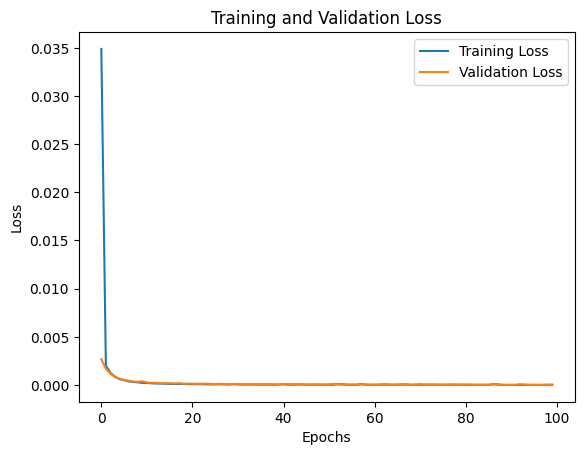

In [8]:
# Visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# Save the model (already saved during training with ModelCheckpoint)
print("Model saved as crispr_model.h5")

Model saved as crispr_model.h5
